# Varible Energy Positron Annihilation Spectroscopy Doppler Broadning Analysis Example
This notebook contains example on how to use pyPAS\
In here, we show chi-square analysis to find the width of the PbS layer on the GaAr\
The sample is divided into 3 Layers which are  PbS surface - Pbs bulk - GaAr,\
According to alpha apectroscopy the width of the PbS layer is 300 +- 30 nm

In [1]:
import numpy as np
import xarray as xr
import pandas as pd

from scipy.optimize import minimize, curve_fit, least_squares
from scipy.constants import nano, micro, centi

import matplotlib.pyplot as plt

from pyPAS.positron_implantation_profile import ghosh_material_parameters, ghosh_profile, multilayer_implantation_profile
from pyPAS.positron_annihilation_profile import positrons_annihilation_profile_solver, profile_annihilation_fraction
from pyPAS.sample import Layer, Material, Sample

from pyspectrum import germanium_fwhm

import dask
from dask.diagnostics import ProgressBar

from itertools import product

from uncertainties import nominal_value, std_dev, ufloat
from uncertainties.unumpy import uarray, nominal_values, std_devs

import warnings

## load the s parameter

In [2]:
lineshape_parm = pd.read_csv('./libs/pbs/pbs2_err.csv', names=['energy', 's', 's_error', 'w', 'w_error'], index_col=0)

s = xr.DataArray(uarray(lineshape_parm.s,lineshape_parm.s_error), coords={'energy':lineshape_parm.index})
w = xr.DataArray(uarray(lineshape_parm.w,lineshape_parm.w_error), coords={'energy':lineshape_parm.index})

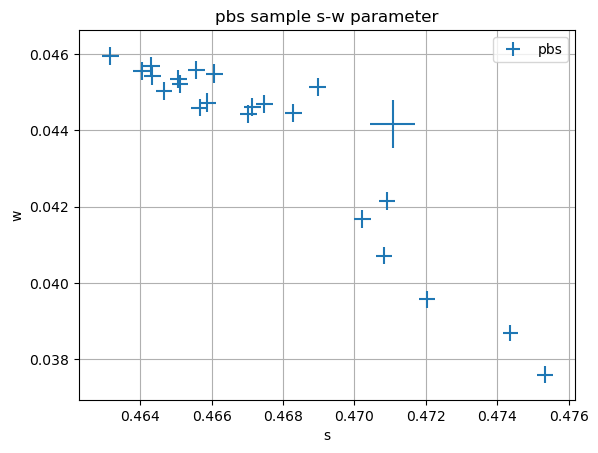

In [3]:
plt.errorbar(x=nominal_values(s), y=nominal_values(w), yerr=std_devs(w), xerr=std_devs(w), ls='')
plt.legend(['pbs'])
plt.title('pbs sample s-w parameter')
plt.xlabel('s')
plt.ylabel('w')
plt.grid(True)

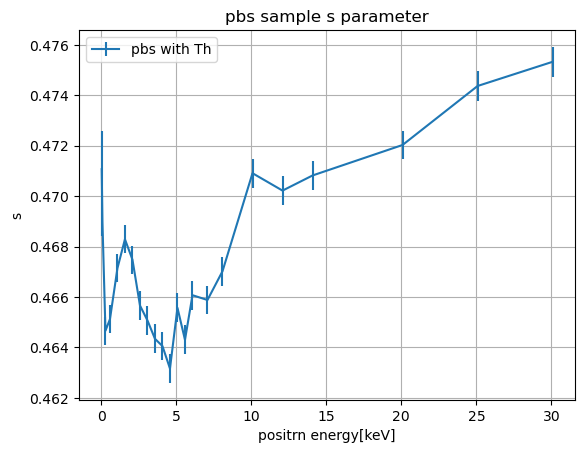

In [4]:
plt.errorbar(x=nominal_values(s.energy), y=nominal_values(s), yerr=std_devs(s), ls='-')
plt.legend(['pbs with Th'])
plt.title('pbs sample s parameter')
plt.xlabel('positrn energy[keV]')
plt.ylabel('s')
plt.grid(True)

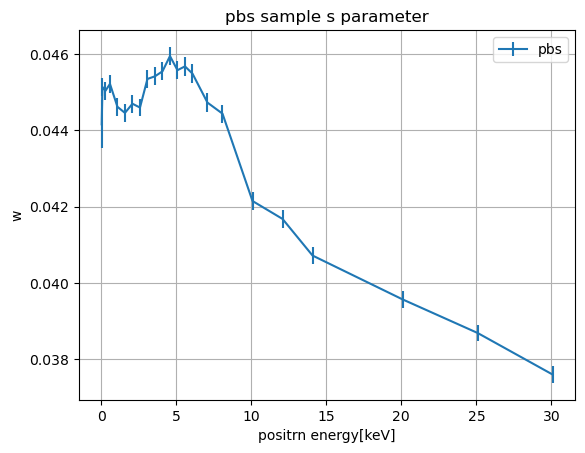

In [5]:
plt.errorbar(x=nominal_values(w.energy), y=nominal_values(w), yerr=std_devs(w), ls='-')
plt.legend(['pbs'])
plt.title('pbs sample s parameter')
plt.xlabel('positrn energy[keV]')
plt.ylabel('w')
plt.grid(True)

# Finding the Layer width of the PbS

In [6]:
# the surface data is ver noisy
s_param = s[5:]

optimization of the diffusion length for 3 layers

In [13]:
class ThreeBulkDiffusionLengthOptimization:
    """
    Optimization to find the bulk diffusion length of a sample.
    This optimization is conducted for one layer sample (surface and bulk).
    Note, given initial Sample with number of annihilation rates, they are summed into one bulk annihilation rate.
    Also, this optimization does not include drift velocity (when there are electric fields)
    Parameters
    ----------
    - positron_implantation_profiles: list
    The profile of the positrons in the sample, this is a list of xarray
    - s_measurement: pd.Series
    The measurement ufloat values of S parameters with the energies as index
    - initial_guess: Sample
    A Sample which is the initial guess of the sample (meaning with diffusion parameter and annihilation rate
    Note, In order to have initial guess of specific diffusion length, L = (D/λ)**0.5
    - num_of_mesh_cells: int Default 10000
    number of cells for the discrimination of the space for the solution of the positron transport equation
    """

    def __init__(self, positron_implantation_profiles: list,
                 s_measurement: pd.Series,
                 initial_guess: Sample,
                 num_of_mesh_cells=10000):
        """
        Parameters
        ----------
         - positron_implantation_profiles: list
          a list of the implantation positron_implantation_profile for each energy
        - s_measurement: pd.Series
         a series of the s measurements, note it as to be the same length as positron_implantation_profiles
         - initial_guess: Sample
         2 parameter for initial guess
        """
        self.positron_implantation_profiles = positron_implantation_profiles
        self.initial_sample = initial_guess
        self.energies = s_measurement.index
        self.s_measurement = nominal_values(s_measurement)
        self.s_measurement_dev = std_devs(s_measurement)
        self.num_of_mesh_cells = num_of_mesh_cells

    def make_sample(self, eff_rate_0, eff_rate_1, eff_rate_2):
        """
        Makes sample with the parameter given alpha_surface and diffusion coefficient
        The annihilation rate in normlized to 1.
        Parameters
        ----------
        - surface_capture_rate: float
        The surface capture rate
        - eff_rate_0, eff_rate_1: float
        The effective rate is the inverse of the diffusion length squared
        Returns
        -------
        sample: Sample
        """
        material_0 = Material(diffusion=1, mobility=0, annihilation_rate_bulk=eff_rate_0)
        material_1 = Material(diffusion=1, mobility=0, annihilation_rate_bulk=eff_rate_1)
        material_2 = Material(diffusion=1, mobility=0, annihilation_rate_bulk=eff_rate_2)

        effective_surface_capture_rate = self.initial_sample.surface_capture_rate/material_0.diffusion

        
        layer_0 = Layer(starting_point=0, width=self.initial_sample.layers[0].width, material=material_0)
        layer_1 = Layer(starting_point=0, width=self.initial_sample.layers[1].width, material=material_1)
        layer_2 = Layer(starting_point=0, width=self.initial_sample.layers[2].width, material=material_2)
        return Sample([layer_0, layer_1, layer_2], effective_surface_capture_rate)

    def rate_matrix(self, sample):
        """
        Calculates the rate matrix of annihilation fractions for a given sample and multiple positron implantation profiles.

        For each implantation profile, the function:
        1. Solves the positron annihilation profile using the provided sample and profile.
        2. Calculates the annihilation fraction in three distinct regions: surface, bulk, and defects.

        Parameters
        ----------
        sample : Sample
            The sample in which positron annihilation takes place.

        Returns
        -------
        annihilation_channel_rate_matrix : np.ndarray
            A transposed matrix where each row corresponds to a profile and contains two values:
            the fraction of positrons annihilating in the surface, bulk, respectively.
        """
        annihilation_channel_rate_matrix = np.zeros((4, len(self.energies)))
        for i, energy in enumerate(self.energies):
            positron_implantation_profile = self.positron_implantation_profiles[i]
            positron_profile_sol = positrons_annihilation_profile_solver(positron_implantation_profile,
                                                                         sample,
                                                                         mesh_size=self.num_of_mesh_cells)
            df = profile_annihilation_fraction(positron_profile_sol, sample)
            annihilation_channel_rate_matrix[0, i] = df.loc[(0, 'surface')].item()
            annihilation_channel_rate_matrix[1, i] = df.loc[(0, 'bulk')].item()
            annihilation_channel_rate_matrix[2, i] = df.loc[(1, 'bulk')].item()
            annihilation_channel_rate_matrix[3, i] = df.loc[(2, 'bulk')].item()
        return np.transpose(annihilation_channel_rate_matrix)

    def s_parameter_calculation(self, energies, eff_rate_0, eff_rate_1, eff_rate_2):
        """
        For given sample, given the sample parameters, function calculate the expected S parameter per energy

        Parameters
        ----------
        - surface_capture_rate: float
        The surface capture rate
        - eff_rate_0, eff_rate_1: float
        The effective rate is the inverse of the diffusion length squared
        Returns
        -------
        s_sample: np.ndarray
        the expected s parameters
        """
        material_0 = Material(diffusion=1, mobility=0, annihilation_rate_bulk=eff_rate_0)        
        eff_surface_capture_rate = self.initial_sample.surface_capture_rate/material_0.diffusion
        
        sample = self.make_sample(eff_rate_0, eff_rate_1, eff_rate_2)
        # find s_parm using linear regression
        annihilation_channel_rate_matrix = self.rate_matrix(sample)
        s_vec = np.linalg.lstsq(annihilation_channel_rate_matrix, self.s_measurement, rcond=None)[0]
        s_sample = annihilation_channel_rate_matrix @ s_vec
        if np.any(s_vec>= 0.75) or np.any(s_vec<.25):
            # if the s value is above 1 or less then 0 make the result high
            return s_sample*np.inf
        return s_sample

    def optimize_diffusion_length(self, bounds=None):
        """
        Function find optimization for the diffusion length in the sample layers

        Parameters
        ----------
        - bounds: list, Default [(0, 0), (np.inf, np.inf)]
        The bounds for the diffusion length parameters
        Returns
        -------
        s_sample: np.ndarray
        the expected s parameters
        """
        # initial guess
        layer_material_0 = (self.initial_sample.layers[0]).material
        layer_material_1 = (self.initial_sample.layers[1]).material
        layer_material_2 = (self.initial_sample.layers[2]).material
        # The effective rate is the inverse of the diffusion length squared
        effective_rate_0 = np.array(list(layer_material_0.rates.values())).sum()/layer_material_0.diffusion
        effective_rate_1 = np.array(list(layer_material_1.rates.values())).sum() / layer_material_1.diffusion
        effective_rate_2 = np.array(list(layer_material_2.rates.values())).sum() / layer_material_2.diffusion
        effective_surface_capture_rate = self.initial_sample.surface_capture_rate/layer_material_0.diffusion

        initial_guess = [effective_surface_capture_rate, effective_rate_0, effective_rate_1, effective_rate_2]
        initial_guess = [effective_rate_0, effective_rate_1, effective_rate_2]

        # set bound of the effective diffusion and the surface_capture_rate
        if bounds is None:
            bounds = [(0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf)]
            bounds = [(0, 0, 0), (np.inf, np.inf, np.inf)]

        else:
            if bounds[1][1] != 0 and bounds[1][1] != 0 and bounds[1][2] != 0 and bounds[1][3] != 0:
                lower_bounds = (1/bounds[1][0], 1/bounds[1][1]**2, 1/bounds[1][2]**2, 1/bounds[1][3]**2)
                lower_bounds = ( 1/bounds[1][1]**2, 1/bounds[1][2]**2, 1/bounds[1][3]**2)

            else:
                warnings.warn("upper bound of L_a and L_b cannot be 0 use small number instead ", ValueError)
                lower_bounds = (0, 0, 0)
            if bounds[0][0] != 0 and bounds[0][1] != 0 and bounds[0][2] != 0 and bounds[0][3] != 0:

                upper_bounds = (1/bounds[0][0], 1/bounds[0][1]**2, 1/bounds[0][2]**2, 1/bounds[0][3]**2)
                upper_bounds = ( 1/bounds[0][1]**2, 1/bounds[0][2]**2, 1/bounds[0][3]**2)

            else:
                upper_bounds = (np.inf, np.inf, np.inf, np.inf)
                upper_bounds = (np.inf, np.inf, np.inf)

            bounds = [lower_bounds, upper_bounds]
        # fit the effective rates
        parm, cov = curve_fit(f=self.s_parameter_calculation, xdata=self.energies, ydata=self.s_measurement,
                              sigma=self.s_measurement_dev, absolute_sigma=True, p0=initial_guess, bounds=bounds)
        # turn the effective rates into diffusion length
        effective_rate_fit_0 = ufloat(parm[0], cov[0, 0]**0.5)
        effective_rate_fit_1 = ufloat(parm[1], cov[1, 1] ** 0.5)
        effective_rate_fit_2 = ufloat(parm[2], cov[2, 2] ** 0.5)
        effective_surface_capture_rate_fit = ufloat(effective_surface_capture_rate,0)#ufloat(parm[0], cov[0, 0]**0.5)
        effective_length = {'layer_2': 1/effective_rate_fit_2**(1/2), 'layer_1': 1/effective_rate_fit_1**(1/2), 'layer_0': 1/effective_rate_fit_0**(1/2),
                            'surface': 1/effective_surface_capture_rate_fit}

        return effective_length

## Fit Example of the Diffusion Length

Material coefficient for implementation profile

In [14]:
data_gos = ghosh_material_parameters()
PbS = ghosh_material_parameters().iloc[23]
GaAs = ghosh_material_parameters().iloc[22]
PbS_density = 7.6
positron_energies = s_param.energy

initial guesss for the diffusion length and the sample shape

In [15]:
# guess true sample 
L0  = 100 * (nano/micro)#0.1 * (nano/micro)
L1  = 40 * (nano/micro)#0.12 * (nano/micro)
L2  = 100 * (nano/micro)

D = 1 * (centi/micro) ** 2 # normal for metals [cm**2/s]
λ_b_0 = D/L0**2 # normal for metals [1/s]
λ_b_1 = D/L1**2 # normal for metals [1/s]
λ_b_2 = D/L2**2 # normal for metals [1/s]

m1 = Material(diffusion=D, mobility=0, annihilation_rate_bulk=λ_b_0)
m2 = Material(diffusion=D, mobility=0, annihilation_rate_bulk=λ_b_1)
m3 = Material(diffusion=D, mobility=0, annihilation_rate_bulk=λ_b_2)

In [76]:
# sample
l0 = Layer(0., 0.06, m1) # infinite sample
l1 = Layer(0., 0.27, m2) # infinite sample
l2 = Layer(0., 20, m2) # infinite sample
alpha = D/(0.1 * (nano/micro)) # assuming around 10 nm

initial_guess_sample = Sample([l0, l1, l2], alpha)

In [77]:
# implentation
depth_vector = np.linspace(0, 10, 100000)
widths = [l0.width, l1.width, l2.width]
materials_parameters = [PbS, PbS, GaAs]
denseties = [PbS_density, PbS_density, GaAs.density]
positron_implementation_profiles = []

for energy in positron_energies:
    positron_implementation_profiles.append(multilayer_implantation_profile(
    positron_energy=energy.item(),
    depth_vector=depth_vector, 
    widths=widths,
    materials_parameters=materials_parameters,
    densities=denseties,
    implantation_profile_function=ghosh_profile     
))


In [78]:
# optimization
vedbfit = ThreeBulkDiffusionLengthOptimization(positron_implementation_profiles, pd.Series(s_param.values, s_param.energy), initial_guess_sample, num_of_mesh_cells=100000)
min_parm = vedbfit.optimize_diffusion_length()

In [79]:
eff_surface_capture_rate, eff_rate_0, eff_rate_1, eff_rate_2 = 1 / nominal_value(min_parm['surface']), 1 / nominal_value(min_parm['layer_0'])**2, 1 / nominal_value(min_parm['layer_1'])**2, 1 / nominal_value(min_parm['layer_2'])**2
s_sample = vedbfit.s_parameter_calculation(vedbfit.energies, eff_rate_0, eff_rate_1, eff_rate_2)

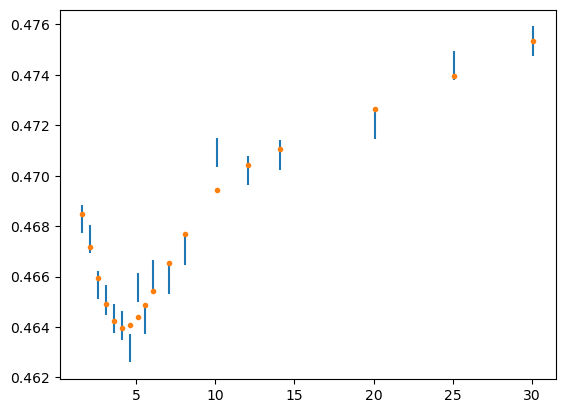

In [80]:
plt.errorbar(x=nominal_values(s_param.energy), y=nominal_values(s_param), yerr=std_devs(s_param), ls='')
plt.plot(nominal_values(s_param.energy), s_sample, '.')

In [81]:
# Chi squared and minimal parameters
((((s_sample - vedbfit.s_measurement)/vedbfit.s_measurement_dev)**2).sum()-len(s_sample)), min_parm

(2.718017776309278,
 {'layer_2': 34.924371403546154+/-6090.276793186475,
  'layer_1': 0.05174887835722575+/-0.022817247888076323,
  'layer_0': 0.12555657928854164+/-6.451071108609087,
  'surface': 0.0001+/-0})

# Calculate the chi-square for various of parameters

define lazy function to calculate the chi square for specific model (given the width of the first two layers)

In [27]:
@dask.delayed
def optimimze_diffusion_length(s_param, x1, x2):
    # sample
    L0  = 100 * (nano/micro)#0.1 * (nano/micro)
    L1  = 100 * (nano/micro)#0.12 * (nano/micro)
    L2  = 3200 * (nano/micro)
    
    D = 1 * (centi/micro) ** 2 # normal for metals [cm**2/s]
    λ_b_0 = D/L0**2 # normal for metals [1/s]
    λ_b_1 = D/L1**2 # normal for metals [1/s]
    λ_b_2 = D/L2**2 # normal for metals [1/s]
    
    m1 = Material(diffusion=D, mobility=0, annihilation_rate_bulk=λ_b_0)
    m2 = Material(diffusion=D, mobility=0, annihilation_rate_bulk=λ_b_1)
    m3 = Material(diffusion=D, mobility=0, annihilation_rate_bulk=λ_b_2)
    
    l0 = Layer(0., x1, m1) # infinite sample
    l1 = Layer(0., x2, m2) # infinite sample
    l2 = Layer(0., 20, m2) # infinite sample
    alpha = D/(10 * (nano/micro)) # assuming around 10 nm
     
    initial_guess_sample = Sample([l0, l1, l2], alpha)
    
    # implentation
    depth_vector = np.linspace(0, 10, 100000)
    widths = [l0.width, l1.width, l2.width]
    materials_parameters = [PbS, PbS, GaAs]
    denseties = [PbS_density, PbS_density, GaAs.density]
    positron_implementation_profiles = []
    
    for energy in positron_energies:
        positron_implementation_profiles.append(multilayer_implantation_profile(
        positron_energy=energy.item(),
        depth_vector=depth_vector, 
        widths=widths,
        materials_parameters=materials_parameters,
        densities=denseties,
        implantation_profile_function=ghosh_profile     
    )) 
    try:
        # optimization
        vedbfit = ThreeBulkDiffusionLengthOptimization(positron_implementation_profiles, pd.Series(s_param.values, s_param.energy), initial_guess_sample, num_of_mesh_cells=100000)
        min_parm = vedbfit.optimize_diffusion_length()
    except:
        return np.nan

    eff_surface_capture_rate, eff_rate_0, eff_rate_1, eff_rate_2 = 1 / nominal_value(min_parm['surface']), 1 / nominal_value(min_parm['layer_0'])**2, 1 / nominal_value(min_parm['layer_1'])**2, 1 / nominal_value(min_parm['layer_2'])**2
    s_sample = vedbfit.s_parameter_calculation(vedbfit.energies, eff_rate_0, eff_rate_1, eff_rate_2)
    
    return (((s_sample - vedbfit.s_measurement)/vedbfit.s_measurement_dev)**2).sum()

In [28]:
chi_sq = optimimze_diffusion_length(s_param, 0.05, 0.2).compute()
chi_sq

22.33846669998396

## Calculate the Chi-square for a grid of likelihood

grid

In [30]:
x_1 = np.arange(10,100,10)* (nano/micro)
x_2 = np.arange(150,300,15)* (nano/micro)

The lazy list of the grid

In [33]:
# Create delayed tasks for the entire grid
lazy_chisq_list = [
    optimimze_diffusion_length(s_param, x1, x2)
    for x1 in x_1 for x2 in x_2
]

In [34]:
# Compute all the results in parallel
with ProgressBar():
    persisted_chisq = dask.persist(*lazy_chisq_list)

[########################################] | 100% Completed | 14hr 21m


In [35]:
chisq_and_parm = dask.compute(persisted_chisq)

In [36]:
chisq = xr.DataArray(np.array(chisq_and_parm[0]).reshape(len(x_1), len(x_2)), coords={'x1':x_1, 'x2':x_2})

In [41]:
# Save to file
chisq.to_netcdf("./libs/results/chisq_data.nc")

In [42]:
# load from file
chisq = xr.load_dataarray("./libs/results/chisq_data.nc")

In [47]:
chisq.to_dataframe('chisq').idxmin().item(), chisq.sel(x1=0.06, x2=0.27, method='nearest')

((0.06, 0.27),
 <xarray.DataArray ()>
 array(20.71882003)
 Coordinates:
     x2       float64 0.27
     x1       float64 0.06)

Text(0, 0.5, 'second layer width [$\\mu$m]')

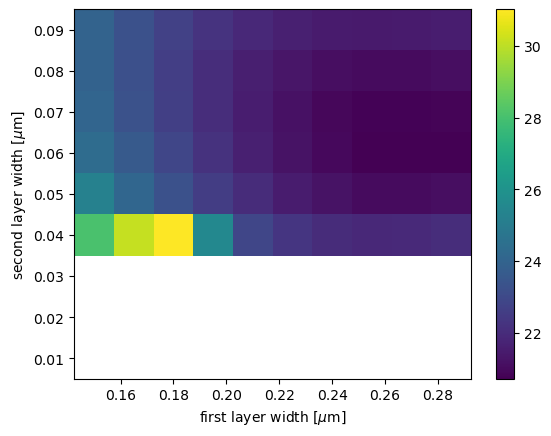

In [58]:
chisq.plot()
plt.xlabel(r'first layer width [$\mu$m]')
plt.ylabel(r'second layer width [$\mu$m]')

It can be obsorved that the best model gives length of 330 nm of PbS.\
However, the model is not good obviously because the chisquare values are to large.
Below is the cdf of 18 variables (the length of the s parameter vector) - the mean is around 16 and the 95-likelihood valueis around 28.
our model dont get values close to the mean which indeicate that the model is not good

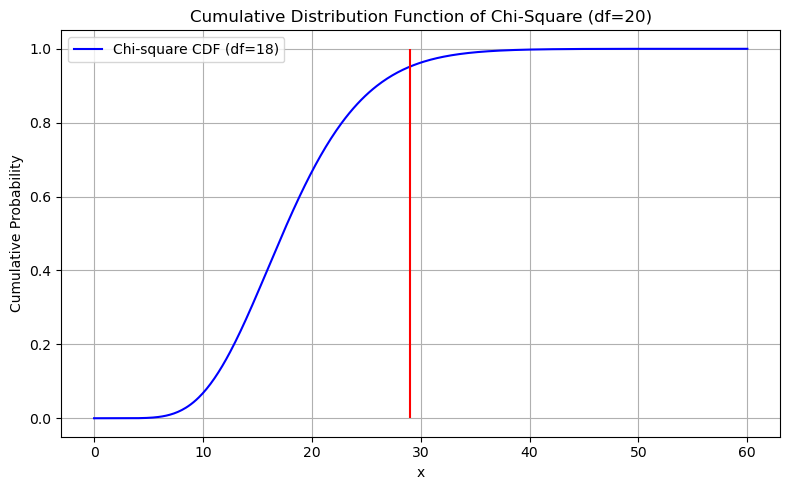

In [75]:
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt

# Degrees of freedom
df = 18

# x values (chi-square variable range)
x = np.linspace(0, 60, 500)

# Compute the cumulative distribution function
cdf = chi2.cdf(x, df)

# Plot the CDF
plt.figure(figsize=(8, 5))
plt.plot(x, cdf, label=f'Chi-square CDF (df={df})', color='blue')
plt.xlabel('x')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function of Chi-Square (df=20)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.vlines(x=x[len(cdf[cdf<0.95])], ymax=1, ymin=0, color='red')

In [68]:
l = (chi2.pdf(x,df))
l.argmax()
x[133]

15.991983967935871